In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [3]:
class SafeAvellanedaStoikovMarketMaker:
    def __init__(self, gamma=0.001, sigma=0.05, T=1.0, k=150, M=0.02, dt=0.005, 
                 max_inventory=5, min_bid=0.01, max_ask=2.0, max_spread=0.10,
                 verbose=False):

        # Core parameters
        self.gamma = max(0.0001, gamma)
        self.sigma = max(0.01, sigma)
        self.T = T
        self.k = k
        self.M = max(0.001, M)
        self.dt = dt
        
        # Safety limits 
        self.max_inventory = max(1, max_inventory)
        self.min_bid = max(0.001, min_bid)
        self.max_ask = max(self.min_bid + 0.01, max_ask)
        self.max_spread = max(0.01, max_spread)
        
        self.verbose = verbose
        self.A = np.exp(self.k * self.M / 2) / self.dt
        self.reset()
    
    def reset(self):
        """Initialize all trading state"""
        self.inventory = 0
        self.cash = 0
        self.current_time = 0
        self.history = {
            'mid_price': [], 'reservation_price': [],
            'bid_price': [], 'ask_price': [],
            'inventory': [], 'cash': [],
            'pnl': [], 'time': [], 'spread': []
        }
    
    def calculate_reservation_price(self, mid_price):
        """Inventory-adjusted valuation with time decay"""
        time_left = max(0.001, self.T - self.current_time)
        return mid_price - self.inventory * self.gamma * self.sigma**2 * time_left
    
    def calculate_optimal_spreads(self, reservation_price, mid_price):
        """Calculate spreads with inventory constraints and price limits"""
        time_left = max(0.001, self.T - self.current_time)
        
        # Base spread with smoother inventory adjustment
        spread_adj = (1/self.gamma) * np.log(1 + self.gamma/self.k)
        inventory_adj = np.tanh(self.inventory/self.max_inventory) * 0.5 * spread_adj
        
        delta_b = min(self.max_spread, inventory_adj + spread_adj)
        delta_a = min(self.max_spread, -inventory_adj + spread_adj)

        
        # Inventory constraints
        if self.inventory >= self.max_inventory:
            delta_b = float('inf')  # Only want to sell
        elif self.inventory <= -self.max_inventory:
            delta_a = float('inf')  # Only want to buy



        # Calculate prices with safeguards
        bid_price = max(self.min_bid, reservation_price - delta_b)
        ask_price = min(self.max_ask, reservation_price + delta_a)
        
        # Enforce maximum spread
        current_spread = ask_price - bid_price
        if current_spread > self.max_spread:
            mid = (bid_price + ask_price)/2
            bid_price = max(self.min_bid, mid - self.max_spread/2)
            ask_price = min(self.max_ask, mid + self.max_spread/2)
        
        return bid_price, ask_price
        
    
    def update_inventory(self, mid_price, bid_executed, ask_executed):
        if bid_executed and abs(self.inventory + 1) <= self.max_inventory:
            self.inventory += 1
            self.cash -= self.bid_price
            if self.verbose:
                print(f"Bought 1 @ {self.bid_price:.4f}")
        
        if ask_executed and abs(self.inventory - 1) <= self.max_inventory:
            self.inventory -= 1
            self.cash += self.ask_price
            if self.verbose:
                print(f"Sold 1 @ {self.ask_price:.4f}")
    
    def calculate_pnl(self, current_mid_price):
        return self.cash + self.inventory * current_mid_price
    
    def step(self, mid_price):
        if mid_price <= 0:
            return False, False
    
        # === QUOTE CALCULATIONS ===
        self.reservation_price = self.calculate_reservation_price(mid_price)
        self.bid_price, self.ask_price = self.calculate_optimal_spreads(
            self.reservation_price, mid_price)
        
        spread_b = max(0.0001, self.reservation_price - self.bid_price)
        spread_a = max(0.0001, self.ask_price - self.reservation_price)
        
        lambda_b = self.A * np.exp(-self.k * spread_b)
        lambda_a = self.A * np.exp(-self.k * spread_a)
        
        # === DEBUG PRINTS: QUOTE STATS ===
        if self.verbose:
            print(f"[t={self.current_time:.3f}] Mid={mid_price:.4f} | "
                  f"Res={self.reservation_price:.4f} | "
                  f"Bid={self.bid_price:.4f} | Ask={self.ask_price:.4f}")
            print(f"Spreads → to_bid={spread_b:.5f}, to_ask={spread_a:.5f}")
            print(f"λ_b*dt={lambda_b * self.dt:.4e}, λ_a*dt={lambda_a * self.dt:.4e}")
    
        # === SIMULATE TRADES ===
        bid_executed = poisson.rvs(lambda_b * self.dt) > 0
        ask_executed = poisson.rvs(lambda_a * self.dt) > 0
    
        # === INVENTORY & CASH UPDATE ===
        self.update_inventory(mid_price, bid_executed, ask_executed)
    
        # === TRACK PERFORMANCE ===
        self.current_time += self.dt
        current_pnl = self.calculate_pnl(mid_price)
    
        self.history['mid_price'].append(mid_price)
        self.history['reservation_price'].append(self.reservation_price)
        self.history['bid_price'].append(self.bid_price)
        self.history['ask_price'].append(self.ask_price)
        self.history['inventory'].append(self.inventory)
        self.history['cash'].append(self.cash)
        self.history['pnl'].append(current_pnl)
        self.history['time'].append(self.current_time)
        self.history['spread'].append(self.ask_price - self.bid_price)
    
        # === DEBUG PNL OUTPUT ===
        if self.verbose:
            print(f"Inv={self.inventory} | Cash={self.cash:.4f} | PnL={current_pnl:.4f}")
            if bid_executed:
                print(f"→ Executed BUY @ {self.bid_price:.4f}")
            if ask_executed:
                print(f"→ Executed SELL @ {self.ask_price:.4f}")
            print("-" * 60)
    
        return bid_executed, ask_executed


    def get_performance_metrics(self):
        return pd.DataFrame(self.history)
    
    def plot_performance(self):
        plt.figure(figsize=(12, 10))
        
        # Price and Quotes
        plt.subplot(3, 1, 1)
        plt.plot(self.history['time'], self.history['mid_price'], label='Mid Price', color='black')
        plt.plot(self.history['time'], self.history['bid_price'], label='Bid', color='red')
        plt.plot(self.history['time'], self.history['ask_price'], label='Ask', color='green')
        plt.ylabel('Price')
        plt.title('Price Dynamics')
        plt.legend()
        
        # Inventory
        plt.subplot(3, 1, 2)
        plt.plot(self.history['time'], self.history['inventory'], label='Inventory', color='blue')
        plt.axhline(self.max_inventory, color='red', linestyle='--')
        plt.axhline(-self.max_inventory, color='red', linestyle='--')
        plt.ylabel('Inventory')
        plt.title('Inventory Position')
        
        # PnL
        plt.subplot(3, 1, 3)
        plt.plot(self.history['time'], self.history['pnl'], label='PnL', color='purple')
        plt.xlabel('Time')
        plt.ylabel('PnL')
        plt.title('Profit and Loss')
        
        plt.tight_layout()
        plt.show()



In [5]:
def load_order_book_data(data_dir):
    all_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv.gz")])
    
    df_list = []
    
    for file in all_files:
        df_tmp = pd.read_csv(file)
    
        # Keep only top 5 levels
        keep_cols = ['timestamp', 'local_timestamp', 'exchange', 'symbol']
        for i in range(5):
            keep_cols += [f'asks[{i}].price', f'asks[{i}].amount', f'bids[{i}].price', f'bids[{i}].amount']
        
        df_tmp = df_tmp[keep_cols]
        df_list.append(df_tmp)
    
    df = pd.concat(df_list, ignore_index=True)  
    return df

In [7]:
# Example usage with performance tracking
if __name__ == "__main__":
    # Load your data
    data_dir = "/Users/diananigmatullina/Downloads/data_thesis"
    df = load_order_book_data(data_dir)
    
    # Calculate mid price from top of book
    df['mid_price'] = (df['asks[0].price'] + df['bids[0].price']) / 2
    


In [8]:
df.head()

,timestamp,local_timestamp,exchange,symbol,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,...,bids[2].amount,asks[3].price,asks[3].amount,bids[3].price,bids[3].amount,asks[4].price,asks[4].amount,bids[4].price,bids[4].amount,mid_price
0,1735689601703988,1735689601703988,binance,DOGEUSDT,0.31601,126244,0.316,87917,0.31602,27345,...,3817,0.31604,24147,0.31597,9272,0.31605,31106,0.31596,7766,0.316005
1,1735689601974000,1735689601975707,binance,DOGEUSDT,0.31601,126244,0.316,87917,0.31602,30507,...,3817,0.31604,21846,0.31597,9272,0.31605,31106,0.31596,7766,0.316005
2,1735689602074000,1735689602075995,binance,DOGEUSDT,0.31601,126244,0.316,87917,0.31602,30507,...,3817,0.31604,21846,0.31597,9272,0.31605,33406,0.31596,7766,0.316005
3,1735689602274000,1735689602275736,binance,DOGEUSDT,0.31601,115444,0.316,87917,0.31602,32089,...,3817,0.31604,21846,0.31597,9272,0.31605,33406,0.31596,7766,0.316005
4,1735689602374000,1735689602375702,binance,DOGEUSDT,0.31601,115444,0.316,87917,0.31602,32880,...,3817,0.31604,29757,0.31597,9272,0.31605,33406,0.31596,7766,0.316005


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Final PnL: 222845.0904
Final Inventory: 1
Max Inventory Reached: 5


/var/folders/pj/l9qbhnfj3ls21fhg4t0fq22w0000gn/T/ipykernel_5094/4183381467.py:191: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


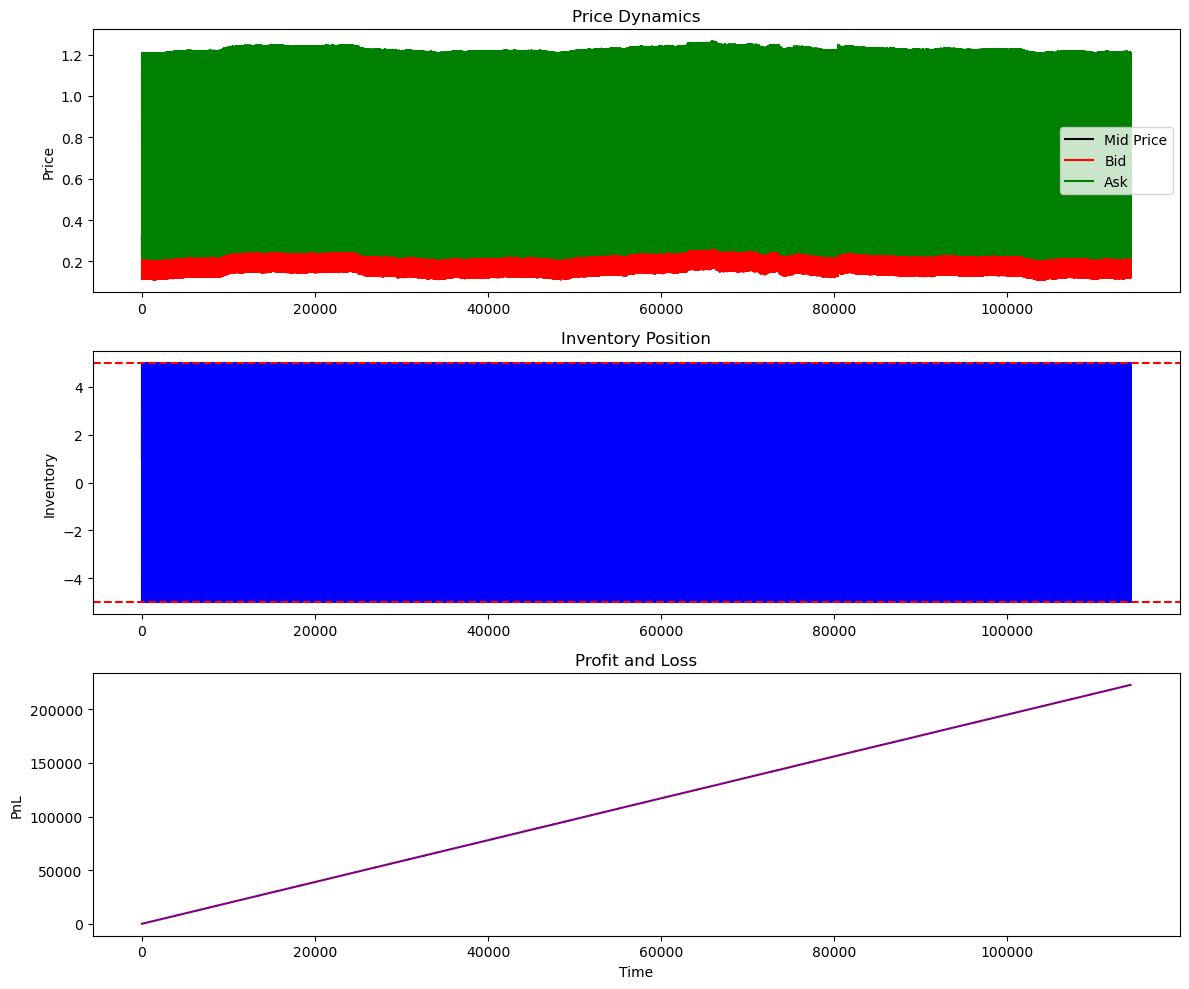

In [11]:
if __name__ == "__main__":
# Initialize with safer parameters
# Further improved parameters
    mm = SafeAvellanedaStoikovMarketMaker(verbose=True)
    
    # Run simulation
    for mid_price in df['mid_price'].values:
        mm.step(mid_price)
    
    # Analyze results
    performance = mm.get_performance_metrics()
    final_pnl = mm.calculate_pnl(df['mid_price'].values[-1])
    
    print(f"\nFinal PnL: {final_pnl:.4f}")
    print(f"Final Inventory: {mm.inventory}")
    print(f"Max Inventory Reached: {max(abs(performance['inventory']))}")
    
    # Plot performance
    mm.plot_performance()
    
    # Save results
    performance.to_csv('market_maker_performance.csv', index=False)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("market_maker_performance.csv")

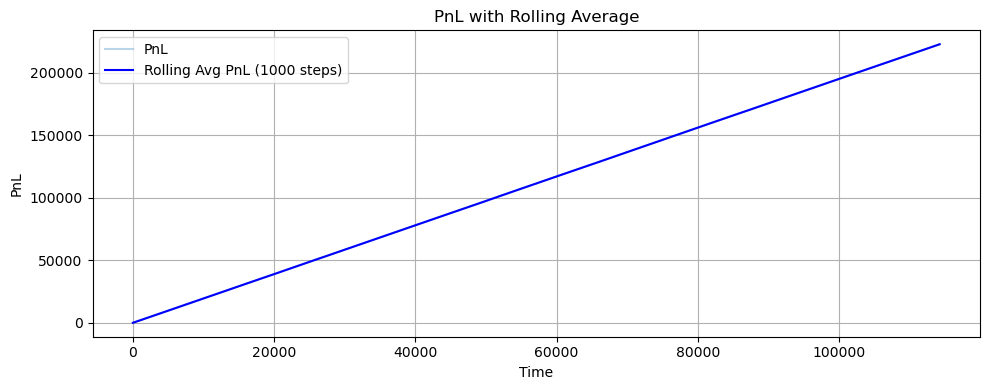

In [14]:
df['rolling_pnl'] = df['pnl'].rolling(1000).mean()

plt.figure(figsize=(10, 4))
plt.plot(df['time'], df['pnl'], label='PnL', alpha=0.3)
plt.plot(df['time'], df['rolling_pnl'], label='Rolling Avg PnL (1000 steps)', color='blue')
plt.xlabel("Time")
plt.ylabel("PnL")
plt.title("PnL with Rolling Average")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

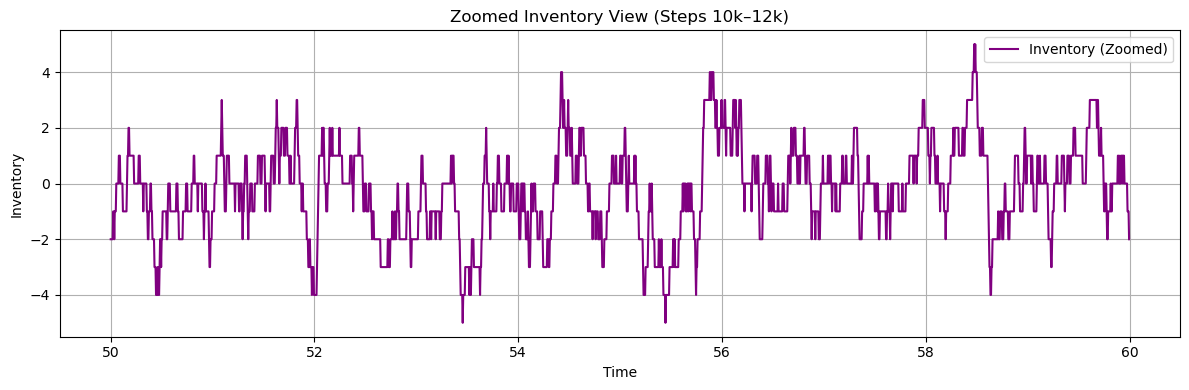

In [33]:
subset = performance[(performance['time'] > 10_000 * mm.dt) & (performance['time'] < 12_000 * mm.dt)]

plt.figure(figsize=(12, 4))
plt.plot(subset['time'], subset['inventory'], label='Inventory (Zoomed)', color='purple')
plt.title("Zoomed Inventory View (Steps 10k–12k)")
plt.xlabel("Time")
plt.ylabel("Inventory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

